In [37]:
import numpy as np
import pandas as pd
import random
from pprint import pprint

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


In [58]:

ENTANGLER_MAP = [[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8]]
#ENTANGLER_MAP_QIDA= [[0,1],[1,2],[2,5],[5,8],[8,7],[7,6],[6,3]]
ENTANGLER_MAP_QIDA= [[0,1],[1,2],[2,5],[5,8],[7,8],[6,7],[3,6]]

In [40]:
#EXTRACT RANDOM COLOR
def randomColor():
    color = random.randrange(0, 2**24)
    hex_color = hex(color)
    std_color = "#" + hex_color[2:]
    return std_color

In [41]:
#EXTRACT ONLY PARAMS t1 AND t2 OF THE N_BLOCK
def extract_N_block(paramslist,ent,depth,offset):
    ct = len(ent)
    n = len(set(np.array(ent).flatten()))
    paramslist = paramslist[n::]
    sliced = []
    for i in range(depth):
        for _ in range(ct):
            if i > (offset-1):
                sliced.append(paramslist[:6:])
            paramslist = paramslist[6::]
        paramslist = paramslist[n::]
    
    relevant = []
    for s in sliced:
        relevant.append(s[2:4:])
    if relevant == []:
        return [],  []
    else:
        relevant = list(np.concatenate(relevant).flat)
        x_ = relevant[::2]
        y_ = relevant[1::2]
        return x_,y_

In [42]:
#EXTRACT INDEX, ENERGIES and COLORS FOR EACH
def plt_energies(data:dict):
    i = []
    en = []
    for item in data:
        i.append(item['Index'])
        en.append(item['Energy'])
    return i,en

In [43]:
#SIMPLY COMPUTE STATS mean, min(best vqe), std and index of best vqe
def stats(e,i):
    return np.mean(e), np.min(e), np.std(e), np.where(e == np.min(e))[0][0]

In [44]:
#CLUSTER THE VQE BASED ON THE DIFFERENCE FROM THE BEST ONE
def threshold_cluster(en, cluster):
    m = np.min(en)
    M = np.max(en)
    n_th = cluster
    delta = np.abs(M - m)/n_th
    th = [m for _ in range(n_th)]
    #th_colors = np.random.rand(cluster)
    th_colors = ['black', '#79002d', '#dc1e72', '#db6fb5', '#dbc8e2']
    l = []
    for j in range(n_th):
        th[j] = m+(delta*j)
    associations = []
    
    for e in en:
        for t in range(len(th)):
            if e<=th[t]:
                l.append(t)
                associations.append(th_colors[t])
                break
        else:

            l.append(len(th))
            associations.append(th_colors[-1])
    return associations, th_colors, delta,l


In [45]:
#CREATE LEGEND OF THE PLOT
def createLegend(cl,string):
    legend = []

    for item,i in enumerate(cl):
        legend.append(Line2D([0], [0], marker='o', color=cl[item], label=string.format(item), markersize=15))
    return legend



FIND THE OPTIMAL VQE FOR QIDA 
1 Layer, 7 entangling gates, 9 qubits


In [61]:

def extract_df(ent, r_col,f,size,depth):
    df = []
    for i in range(1,size+1):
        print(i)
        p = pd.read_pickle(f.format(i,depth))[0]
        x_,y_ = extract_N_block(p["Optimal_params"],ent, depth,0)
        data = dict()
        if r_col:
            c = randomColor()
            while len(c)!=7:
                c = randomColor()
        if r_col:
            data.update({"x_params":x_, "y_params":y_, "color": c,"Energy":p['Energy'],"Index": i })
        else:
            data.update({"x_params":x_, "y_params":y_, "Energy":p['Energy'], "Index": i })

        df.append(data)
    return df


In [47]:
#CHECK DI QUESTA FUNZIONE
#RIMOSSO INDICE
def clean_df(en,i):
    new_en = []
    new_i = []
    mean_e = np.mean(en)
    for e in range(len(en)):
        if mean_e>=en[e]:
            new_en.append(en[e])
            new_i.append(i[e])
        else:
            pass
    return new_i, new_en

In [48]:
#CREATE PARAMETERS PAIRS
def parameter_pair(df, i,ass):
    x_ = []
    y_ = []
    rep = len(df[0]['x_params'])
    for item in df:
        if item['Index'] in i:
            x_.append(item["x_params"])
            y_.append(item["y_params"])
    cmap = list()
    for item in ass:
        for _ in range(rep):
            cmap.append(item)

    return x_,y_,cmap

In [49]:
def parameter_pair_multilayer(color_list, reps):
    parameters_color = []
    print(len(color_list), len(reps))
    for i in range(len(color_list)):
        for _ in range(reps[i]):
            parameters_color.append(color_list[i])
    return parameters_color

In [54]:
def size_plot (idx, s_min, s_all, l, rep):
    temp = []
    temp_a = []
    for i in range(l):
        if i == idx:
            temp.append(s_min)
            temp_a.append(1)
        else:
            
            temp.append(s_all)
            temp_a.append(0.4)
    s = []
    a = []
    for item in range(len(temp)):
        for _ in range(rep):
            s.append(temp[item])
            a.append(temp_a[item])
    return s, a

In [51]:
#SELECT ONLY SOME THRESHOLDS
def cut_th(en,i,col,l,th):
    new_en = []
    new_col = []
    new_i = [] 
    for j in range(len(l)):
        if l[j] < th:
            new_en.append(en[j])
            new_col.append(col[j])
            new_i.append(i[j])
    return new_en, new_i, new_col

CREAZIONE PLOT CON COLOMAp DIVISA PER SOGLIE

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


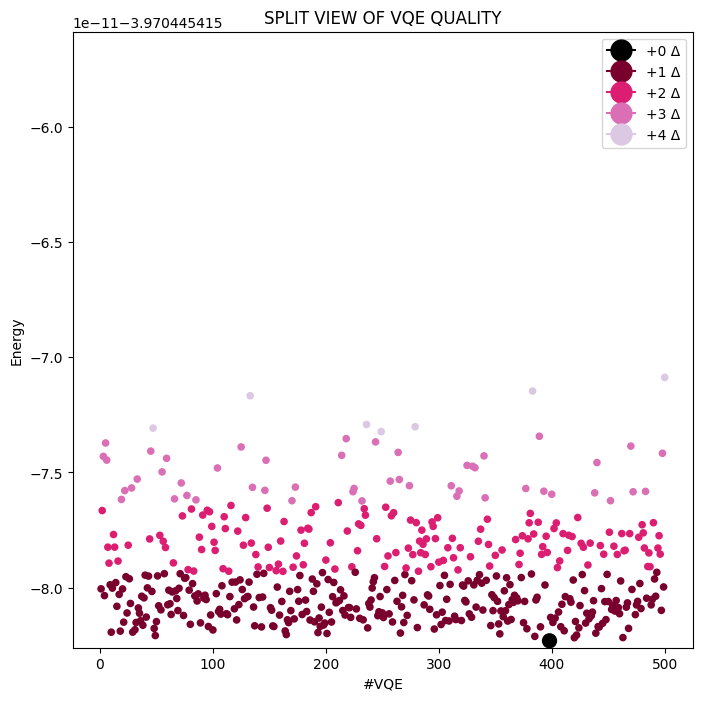

In [63]:

file_qida = "./pickle/vqe{}_3x3_{}A+_SU4.pkl"
file_ladder = "./pickle/vqe{}_3x3_ladder_{}SU4.pkl"

df = extract_df(ent=ENTANGLER_MAP_QIDA, r_col=False, f=file_qida, size = 500,depth=1)
i,en= plt_energies(data = df)
print(np.min(en))
_, best_vqe, vqe_std, best_vqe_ind = stats(en, i)
print(best_vqe, i[best_vqe_ind])
i,en = clean_df(en,i)
col,legend_color,delta,l = threshold_cluster(en=en, cluster = 5)

stop_th = 5


en, i, col= cut_th(en=en,i=i, l=l, th=stop_th, col = col)
_,best_vqe,_, best_vqe_ind = stats(en, i)
print(best_vqe,i[best_vqe_ind])


plt.figure(figsize=(8, 8))
s = [20]*len(i)
s[best_vqe_ind] = 100


plt.scatter(i, en, s=s,c = col)

string = "+{} Δ"
plt.legend(handles=createLegend(legend_color[:stop_th],string))

#plt.xlim(0,len(en)+1)

plt.axhline(-4.7493272585529, c='b')
plt.axhline(-3, c='r')
plt.ylim(np.min(en)-(delta/10), np.max(en)+(5*delta))

plt.xlabel('#VQE')
plt.ylabel('Energy')

plt.title('SPLIT VIEW OF VQE QUALITY')
plt.show()


494 494 3458


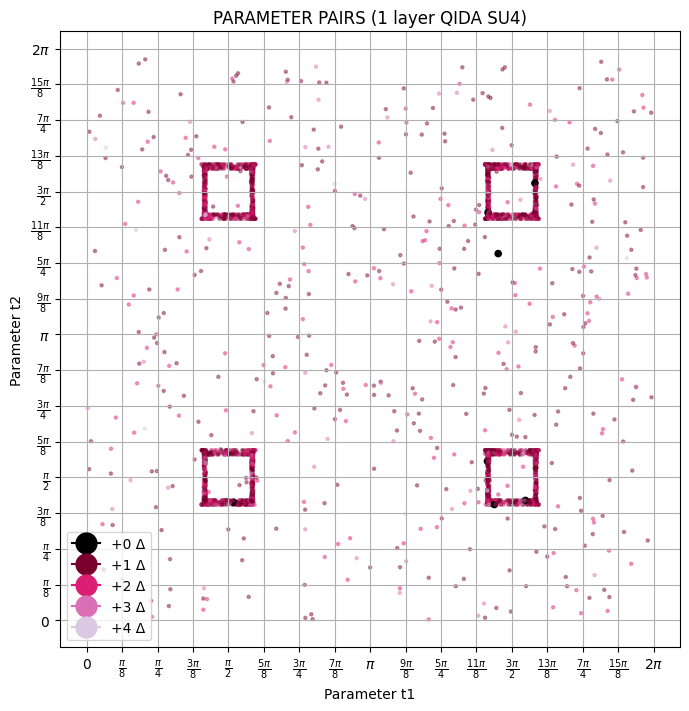

In [64]:
x_param, y_param, cmap = parameter_pair(df=df,i=i,ass = col)
print(len(x_param), len(y_param), len(cmap))
s, a = size_plot(idx=best_vqe_ind, s_min=20, s_all=5, l=len(en), rep = int(len(cmap)/len(en)))


plt.figure(figsize = (8,8))
plt.title("PARAMETER PAIRS (1 layer QIDA SU4)")
string = "+{} Δ"
plt.legend(handles=createLegend(legend_color[:stop_th],string))

plt.scatter(np.mod(x_param,2*np.pi), np.mod(y_param, 2*np.pi), c=cmap, alpha=a, s=s)

plt.xticks(np.linspace(0, 2*np.pi, 17), [r'$0$',  r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$', r'$\frac{5\pi}{8}$',
                                        r'$\frac{3\pi}{4}$', r'$\frac{7\pi}{8}$', r'$\pi}$', r'$\frac{9\pi}{8}$', r'$\frac{5\pi}{4}$', r'$\frac{11\pi}{8}$',
                                        r'$\frac{3\pi}{2}$', r'$\frac{13\pi}{8}$', r'$\frac{7\pi}{4}$', r'$\frac{15\pi}{8}$', r'$2\pi$'])
plt.yticks(np.linspace(0, 2*np.pi, 17), [r'$0$',  r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$', r'$\frac{5\pi}{8}$',
                                        r'$\frac{3\pi}{4}$', r'$\frac{7\pi}{8}$', r'$\pi}$', r'$\frac{9\pi}{8}$', r'$\frac{5\pi}{4}$', r'$\frac{11\pi}{8}$',
                                        r'$\frac{3\pi}{2}$', r'$\frac{13\pi}{8}$', r'$\frac{7\pi}{4}$', r'$\frac{15\pi}{8}$', r'$2\pi$'])
plt.grid(True)
plt.xlabel('Parameter t1')
plt.ylabel('Parameter t2')
plt.show()

LADDER RESULTS


In [18]:

def extract_df_multidepth(depth,offset, ent,f,size):
    vqe_colors = []
    param_colors = []
    rep = []
    color_label  = ['black', '#79002d', '#dc1e72', '#db6fb5', '#fc9dbc','#dbc8e2','grey']
    total_x = []
    total_y = []
    en = []
    index = []
    
    for j in range(offset,depth+1):
        for i in range(1,size+1):
            p = pd.read_pickle(f.format(i,j))[0]
            x_,y_ = extract_N_block(p["Optimal_params"],ent, j,0)
            en.append(p["Energy"])
            total_x.append(x_)
            total_y.append(y_)
            for _ in range(len(x_)):
                param_colors.append(color_label[j-1])

            rep.append(len(x_))
            vqe_colors.append(color_label[j-1])
            index.append(i+(j-1)*size)
    return total_x, total_y, color_label, param_colors,vqe_colors,rep, index, en

In [25]:
file_ladder = "./pickle/vqe{}_3x3_ladder_{}SU4.pkl"

offset = 1
depth = 1
total_x,total_y,color_label,colors,vqe_colors,reps,index,en = extract_df_multidepth(depth=depth,offset=offset,ent=ENTANGLER_MAP, f=file_ladder, size = 50)
print(len(index), len(en))
total_x = list(np.concatenate(total_x).flat)
total_y = list(np.concatenate(total_y).flat)
print(reps)

50 50
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]


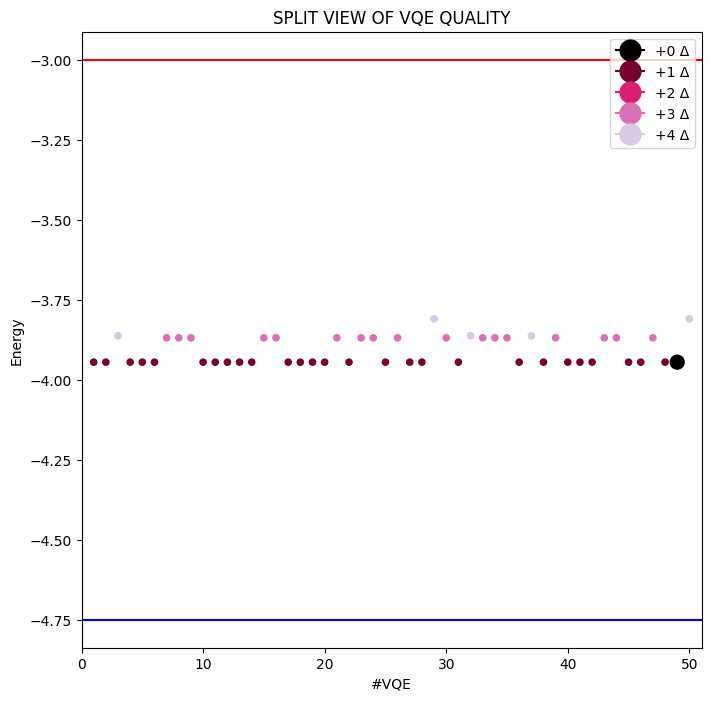

In [30]:
plt.figure(figsize=(8, 8))
s = 5
string = "{} layers"
if offset==depth:
    col,legend_color,delta,l = threshold_cluster(en=en, cluster = 5) 
    vqe_colors = col
    color_label = legend_color
    _,best_vqe,_, best_vqe_ind = stats(en, index)
    s = [20]*len(index)
    s[best_vqe_ind] = 100
    string = "+{} Δ"
    
plt.scatter(index, en, s=s,c=vqe_colors)

plt.axhline(-4.7493272585529, c='b')
plt.axhline(-3, c='r')
plt.legend(handles=createLegend(color_label, string))

plt.xlim(50*(offset-1),len(en)*(offset)+1)
#plt.ylim(np.min(en)-(delta/10), np.max(en)+(delta))

plt.xlabel('#VQE')
plt.ylabel('Energy')

plt.title('SPLIT VIEW OF VQE QUALITY')
plt.show()

50 50


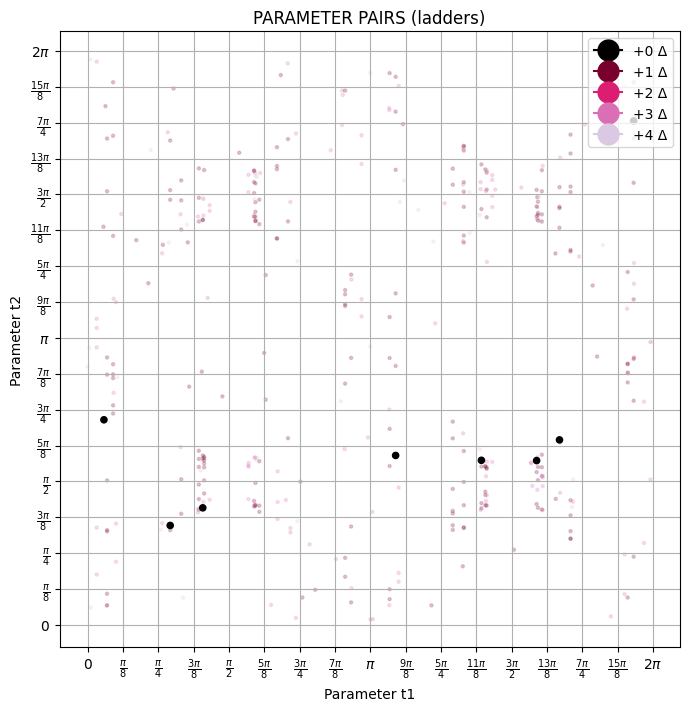

In [31]:
a = 1
s = 2
if depth == offset:
    colors = parameter_pair_multilayer(vqe_colors, reps)
    s, a = size_plot(idx=best_vqe_ind, s_min=20, s_all=5, l=len(en), rep = reps[0])  
plt.figure(figsize = (8,8))
plt.title("PARAMETER PAIRS (ladders)")
plt.legend(handles=createLegend(color_label, string))

plt.scatter(np.mod(total_x,2*np.pi), np.mod(total_y, 2*np.pi), c=colors, alpha=a, s=s)

plt.xticks(np.linspace(0, 2*np.pi, 17), [r'$0$',  r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$', r'$\frac{5\pi}{8}$',
                                        r'$\frac{3\pi}{4}$', r'$\frac{7\pi}{8}$', r'$\pi}$', r'$\frac{9\pi}{8}$', r'$\frac{5\pi}{4}$', r'$\frac{11\pi}{8}$',
                                        r'$\frac{3\pi}{2}$', r'$\frac{13\pi}{8}$', r'$\frac{7\pi}{4}$', r'$\frac{15\pi}{8}$', r'$2\pi$'])
plt.yticks(np.linspace(0, 2*np.pi, 17), [r'$0$',  r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$', r'$\frac{5\pi}{8}$',
                                        r'$\frac{3\pi}{4}$', r'$\frac{7\pi}{8}$', r'$\pi}$', r'$\frac{9\pi}{8}$', r'$\frac{5\pi}{4}$', r'$\frac{11\pi}{8}$',
                                        r'$\frac{3\pi}{2}$', r'$\frac{13\pi}{8}$', r'$\frac{7\pi}{4}$', r'$\frac{15\pi}{8}$', r'$2\pi$'])
plt.grid(True)
plt.xlabel('Parameter t1')
plt.ylabel('Parameter t2')
plt.show()

CLUSTER ROTATION MATRICES

In [ ]:
# 1-QUBIT GATES
I = np.eye(2)
Z = np.array([[1., 0.],[0. ,-1.]])
X = np.array([[0., 1.],[1. ,0.]])
Y = np.array([[0., -1.j],[1.j ,0.]])

# 2-QUBITs GATES
I4 = np.eye(4)
CNOT1 = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
CNOT2 = np.array([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]])

CZ = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,-1]])

CY1 = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,-1j],[0,0,1j,0]])
CY2 = np.array([[1,0,0,0],[0,0,0,-1j],[0,0,1,0],[0,1j,0,0]])

CH1 = np.array([[1,0,0,0],[0,1,0,0],[0,0,1/np.sqrt(2),1/np.sqrt(2)],[0,0,1/np.sqrt(2),-1/np.sqrt(2)]])
CH2 = np.array([[1,0,0,0],[0,1/np.sqrt(2),0,1/np.sqrt(2)],[0,0,1,0],[0,1/np.sqrt(2),0,-1/np.sqrt(2)]])

SWAP = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])
iSWAP = np.array([[1,0,0,0],[0,0,1j,0],[0,1j,0,0],[0,0,0,1]])

M_LIST = [I4, 
          CNOT1, CNOT2,
          CZ,
          CY1,
          CY2,
          CH1,
          CH2,
          SWAP, iSWAP]


In [ ]:
#COMPOSES RY(theta)
def ry(theta):
    a = np.cos(theta/2)
    b = np.sin(theta/2)
    return np.array([[a,-b],[b,a]])


In [ ]:
#COMPOSE N_BLOCK FROM PARAMETERS t1 AND t2
def compose_N_block(t1, t2):
    return CNOT2 @ np.kron(I, ry(t1)) @ CNOT1 @ np.kron(I, ry(t2)) @ CNOT2


In [ ]:
#COMPOSE SU(4) FROM LIST OF PARAMETERS
def compose_su4(params):
    return np.kron(ry(params[0]),I) @ np.kron(I, ry(params[1])) @ compose_N_block(params[2], params[3]) @ np.kron(ry(params[4]),I) @ np.kron(I, ry(params[5]))


COMPUTE RY ROTATION FOR $$\theta \in \{0, \frac{\pi}{2}, \pi, \frac{3\pi}{2}\}$$

In [ ]:
#COMPUTE THE RY ROTATION IN THE CENTER OF THE CLUSTER
halfs = [np.pi*k/2 for k in range(0,5)]
for i in halfs:
    print("Val:{}\n{}\n".format(i,np.round(ry(np.mod(i,2*np.pi)),4)))

GENERAL $R_y(\theta)$ ROTATION IS DEFINED AS
$$R_y(\theta) = \begin{bmatrix}\cos(\frac{\theta}{2})&-\sin(\frac{\theta}{2})\\ \\\sin(\frac{\theta}{2})&\cos(\frac{\theta}{2})\end{bmatrix}$$

FOR $\theta = \pi$
$$R_y(\pi) = \begin{bmatrix}0&-1\\1&0\end{bmatrix} = -i\sigma_y$$

FOR $\frac{\pi}{2}+k\pi$
$$R_y(\frac{\pi}{2}) = \frac{1}{\sqrt(2)}\begin{bmatrix}1&-1\\1&1\end{bmatrix}$$
WHICH ACT LIKE:
$$R_y(\frac{\pi}{2})\ket{0}= \ket{+}$$
$$R_y(\frac{\pi}{2})\ket{1}= -\ket{-}$$
 
$\space$
 
$$R_y(\frac{3\pi}{2})\ket{0}= -\ket{-}$$
$$R_y(\frac{3\pi}{2})\ket{1}= -\ket{+}$$

CIRCUIT CORRESPONDECE FOR SU(4) GATES

In [ ]:
#CREATION OF SU(4) GATES
from qiskit.circuit import Parameter, QuantumCircuit

def general_SU4(counter, qc, q0,q1,M):
    def add_single_SU2 (counter, qc,q, M):

        #counter = counter + 1
        #qc.rz(Parameter(parameterBitString(M,counter)),q)

        counter = counter + 1
        qc.ry(Parameter(parameterBitString(M,counter)),q)

        #counter = counter + 1
        #qc.rz(Parameter(parameterBitString(M,counter)),q)
        return counter


    def add_N_block(counter, qc, q0,q1, M):
        qc.cx(q1, q0)

        #counter = counter + 1
        #qc.rz(Parameter(parameterBitString(M,counter)),q0)
        
        counter = counter + 1
        qc.ry(Parameter(parameterBitString(M,counter)),q1)


        qc.cx(q0, q1)
        
        counter = counter + 1
        qc.ry(Parameter(parameterBitString(M,counter)),q1)
        
        qc.cx(q1, q0)

        return counter

    counter = add_single_SU2(counter, qc, q0, M)
    counter = add_single_SU2(counter, qc, q1, M)
    qc.barrier()
    counter = add_N_block(counter, qc, q0,q1, M)
    qc.barrier()
    counter = add_single_SU2(counter, qc, q0, M)
    counter = add_single_SU2(counter, qc, q1, M)
    qc.barrier()
    return counter


def parameterBitString(M,i):
    return format(i,'b').zfill(M)

In [ ]:
#CREATE CIRCUIT
def create_circuit(q, M, ent, depth,draw):

    qc = QuantumCircuit(q)  
    count = 0
    for d in range(0,depth):
        for i in range(0,q):
            if i in(set(np.array(ent).flatten())):
                count = count + 1
                qc.rz(Parameter(parameterBitString(M,count)),i)
        
        qc.barrier()

        for a,b in ent:
            count = general_SU4(count, qc, a, b,M)
            
    for i in range(0,q):
        count = count + 1
        qc.rz(Parameter(parameterBitString(M,count)),i)
    if draw:
        print(qc.draw())
    print("#PARAMETERS:",qc.num_parameters)
    print("#CNOTS:",qc.num_nonlocal_gates())
    return qc


In [ ]:
qc = create_circuit(9, 10 , ENTANGLER_MAP_QIDA,1, draw=False)